<a href="https://colab.research.google.com/github/mariakuria/Comparison-of-NLP-models/blob/main/intro_to_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification using BERT**


BERT stands for Bidirectional Encoder Representations from Transformers. It is an advanced, pre-trained NLP model that understands language by looking at the context of each word. Because BERT has already been created and pre-trained for us (by Google), it can be fine-tuned for our finance task by adding just one additional output layer—just like that, we can create a state-of-the-art model.



In [ ]:
#Preparing environment

!pip install transformers
import os
import gdown
import torch
import numpy as np
import seaborn as sns
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn import metrics

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

%matplotlib inline

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
NONE = 4 * [None]
RND_SEED=2020

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(14,12))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

In [ ]:
df_train = get_finance_train()
df_test = get_finance_test()

In [ ]:
sentences = df_train["Sentence"].values
labels = df_train["Label"]

When using BERT, our text needs to be split into tokens and those tokens need to be mapped to an index using BERT's vocabulary. We will use the `BertTokenizer` module from the transformer library to tokenize our data. We'll call the function `BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)` and save the returned value in a variable named `tokenizer`.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

In [ ]:
print(tokenizer.vocab_size)

30522


Now, we map the tokens to indices on the first element in your training dataset: `sentences[0]`. We'll use the `convert_tokens_to_ids()` function of the `tokenizer` to encode our word tokens into numerical values. Then we'll the command `tokenizer.convert_tokens_to_ids(TOKENIZED_SENTENCE)` passing in the tokenized version of `sentences[0]` that we created above for `TOKENIZED_SENTENCE`.

In [ ]:
TOKENIZED_SENTENCE = tokenizer.tokenize(sentences[0])
tokenizer.convert_tokens_to_ids(TOKENIZED_SENTENCE)

[8285,
 5794,
 2243,
 2177,
 2003,
 2112,
 1997,
 2004,
 6873,
 1005,
 1055,
 3001,
 2407,
 1012]

In [ ]:
sentences_with_special_tokens = []

for sentence in sentences:
  sentences_with_special_tokens.append("[CLS] " + sentence + "[ SEP]")

print(sentences_with_special_tokens[0])

NameError: name 'sentences' is not defined

In [ ]:
tokenized_texts = []

for sentence in sentences_with_special_tokens:
  tokenized_texts.append(tokenizer.tokenize(sentence))

print(tokenized_texts[0])


['[CLS]', 'auto', '##tan', '##k', 'group', 'is', 'part', 'of', 'as', '##po', "'", 's', 'systems', 'division', '.', '[', 'sep', ']']


#### **Encode tokenized sentences with indices**

Before we properly pad the sentences, we will first map each token to its corresponding index for each tokenized sentence. To do so, we will loop through your `tokenized_texts` variable call the `tokenizer.convert_tokens_to_ids(TOKENIZED_SENTENCE)` while passing in your tokenized sentence to convert it to a list of corresponding indices.

In [ ]:
input_ids = []
for tokenized_text in tokenized_texts:
    input_ids.append(tokenizer.convert_tokens_to_ids(tokenized_text))

print(input_ids[0])

[101, 8285, 5794, 2243, 2177, 2003, 2112, 1997, 2004, 6873, 1005, 1055, 3001, 2407, 1012, 1031, 19802, 1033]


#### **Padding our input**

Now we will pad our input to ensure that every sequence has the same length. To do so, we will utilize the `keras` function named `pad_sequences()`.

In [ ]:
input_ids = pad_sequences(input_ids,
                          maxlen=128, ### YOUR CODE HERE
                          dtype="long",
                          truncating="post",
                          padding="post")
print(input_ids[0])

[  101  8285  5794  2243  2177  2003  2112  1997  2004  6873  1005  1055
  3001  2407  1012  1031 19802  1033     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


####**Attention Masks**####

An Attention Mask is an array of 1s and 0s indicating which tokens are padding and which are not. The idea behind attention masks is that we do not want the extra padded sequence tokens to contribute to the input features of the machine learning model. So, we essentially zero them out to highlight their insignificance before passing them through the model.

Each sequence has a corresponding attention mask. Consider the input sequence below and its corresponding attention mask. We want to create an attention mask for each sequence before passing our data through the BERT model.






In [ ]:
attention_masks = []

for input_id in input_ids:
  mask=[float(i>0) for i in input_id]
  attention_masks.append(mask)

print (attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## **Setting up your Data for BERT**

Now, we need to split our data and convert it to objects that will work most efficiently with the BERT model training procedure.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels,test_size=0.15, random_state=RND_SEED) ### YOUR CODE HERE

We also want to split our attention masks in the same way.

In [ ]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.15, random_state=RND_SEED ) ### YOUR CODE HERE

In [ ]:
#Converting data to tensors and create DataLoaders
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); # Samples data randonly for training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); # Samples data sequentially
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

In [ ]:
#Initializing BertForSequenceClassification model
#Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT small model, with an uncased vocab.
    num_labels = 3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
);

# Given that this a huge neural network, we need to explicity specify
# in pytorch to run this model on the GPU.
model.cuda();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

'Tesla T4'

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, ### YOUR CODE HERE
                  eps = 1e-8
                )
epochs = 4

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#Training your model!

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# We'll store training and validation loss,
# validation accuracy, and timings.
training_loss = []
validation_loss = []
training_stats = []
for epoch_i in range(0, epochs):
    # Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    # Reset the total loss for  epoch.
    total_train_loss = 0
    # Put the model into training mode.
    model.train()
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        # STEP 1 & 2: Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # STEP 3
        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # STEP 4
        # Perform a forward pass (evaluate the model on this training batch).
        # It returns the loss (because we provided labels) and
        # the "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # STEP 5
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # STEP 6
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # Validation
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("Evaluating on Validation Set")
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        #Step 1 and Step 2
        # Unpack this validation batch from our dataloader.

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)



    print("Validation Loss: {0:.2f}".format(avg_val_loss))


    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy

        }
    )

print("Training complete!")

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.62
Evaluating on Validation Set
Validation Accuracy: 0.80
Validation Loss: 0.41
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.23
Evaluating on Validation Set
Validation Accuracy: 0.95
Validation Loss: 0.16
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.08
Evaluating on Validation Set
Validation Accuracy: 0.95
Validation Loss: 0.20
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.05
Evaluating on Validation Set
Validation Accuracy: 0.96
Validation Loss: 0.14
Training complete!


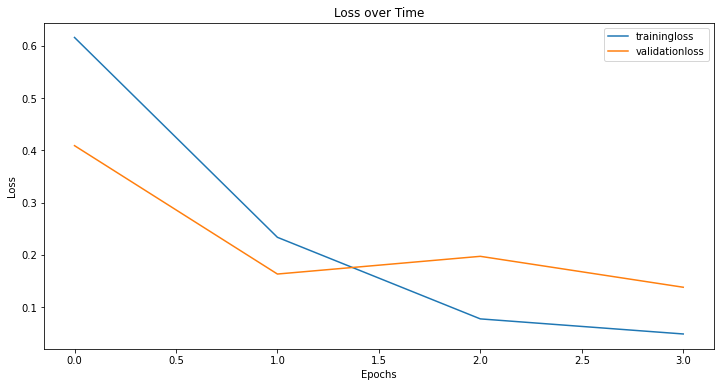

In [ ]:
#Plotting Losses

fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

### YOUR CODE HERE
plt.plot(training_loss, label = "trainingloss")
plt.plot(validation_loss, label = "validationloss")
### END CODE

plt.legend()
plt.show()

In [ ]:
test_sentences = df_test["Sentence"].values
test_labels = df_test["Label"].values

Now we will format our test input data similarly to how we formatted our training input data.

In [ ]:
#Processing and preparing our test data!
test_input_ids, test_attention_masks = [], []

# Add Special Tokens
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

# Tokenize sentences
tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

# Encode Tokens to Word IDs
test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

# Pad the inputs
test_input_ids = pad_sequences(test_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")

# Creating Attention Masks
for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [ ]:
#Converting data to tensors and create DataLoaders
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Predicting labels for 227 test sentences...
Test Accuracy: 94.71%
Plotting the Confusion Matrix


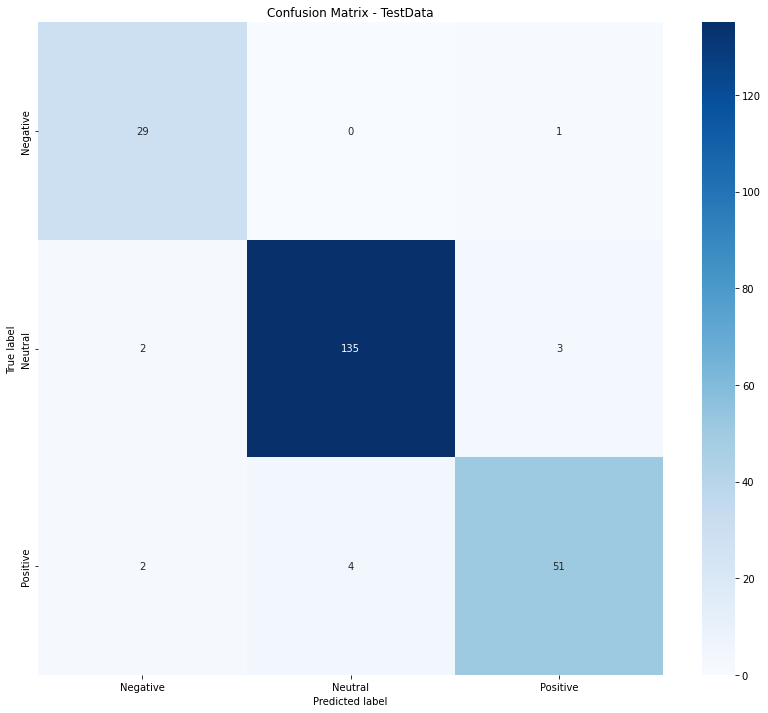

In [ ]:
#Evaluating Test Set Accuracy!
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Final tracking variables
y_logits, y_true, y_preds = [], [], []

# Gather logit predictions
for chunk in predictions:
  for logits in chunk:
    y_logits.append(logits)

# Gather true labels
for chunk in true_labels:
  for label in chunk:
    y_true.append(label)

# Gather real predictions
for logits in y_logits:
  y_preds.append(np.argmax(logits))

print ('Test Accuracy: {:.2%}'.format(metrics.accuracy_score(y_preds,y_true)))
plot_confusion_matrix(y_true,y_preds)